# **Proyek Akhir : Membuat Model Sistem Rekomendasi**

### **Latar Belakang**

Dalam era informasi yang terus berkembang, masyarakat kini dihadapkan pada berbagai pilihan buku yang semakin luas, dari berbagai genre hingga format digital dan cetak. Jumlah buku yang diterbitkan terus bertambah, membuat pengguna kerap kesulitan menemukan buku yang sesuai dengan minat, kebutuhan, atau preferensi mereka. Selain itu, perkembangan teknologi informasi memungkinkan terciptanya sistem yang dapat membantu individu dalam menavigasi pilihan-pilihan ini secara lebih efisien, sehingga pengalaman membaca menjadi lebih personal dan memuaskan.

Sistem rekomendasi adalah salah satu pendekatan teknologi yang telah terbukti mampu membantu pengguna dalam memilih konten yang relevan, baik itu dalam bentuk film, musik, produk, hingga buku. Di bidang perbukuan, sistem rekomendasi memiliki potensi besar dalam membantu pengguna mengatasi kesulitan memilih buku yang sesuai dengan preferensi mereka. Dengan menggunakan data pengguna, sistem ini dapat memberikan rekomendasi buku yang lebih terarah dan personal, sehingga membantu dalam meningkatkan minat baca dan waktu yang dihabiskan untuk membaca, terutama di kalangan masyarakat yang memiliki keterbatasan waktu atau akses terhadap buku.

### **Pentingnya Proyek**

* Mempermudah pengguna dalam menemukan buku yang sesuai dengan minat dan
preferensi mereka di tengah pilihan buku yang semakin luas.
* Meningkatkan minat baca masyarakat dengan menyediakan rekomendasi buku yang personal dan relevan.
* Membantu platform seperti perpustakaan digital, toko buku online, atau aplikasi edukasi untuk meningkatkan keterlibatan pengguna, waktu penggunaan, dan potensi penjualan atau peminjaman buku.
* Berkontribusi pada peningkatan literasi masyarakat, terutama di era digital yang menantang minat baca generasi muda.

# **1. Import Library**

In [3]:
!pip install kagglehub

In [4]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path
import matplotlib.pyplot as plt
import kagglehub

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# **2. Data Understanding**

## **2.1 Data Loading**

**Penjelasan Kode :**

Kode ini bertujuan untuk mengunduh dan memuat dataset rekomendasi buku dari Kaggle, lalu membaca tiga file utama (`Books.csv`, `Ratings.csv`, dan `Users.csv`) untuk digunakan dalam pembangunan sistem rekomendasi. Ketiga DataFrame ini merupakan komponen kunci untuk analisis dan pengembangan model rekomendasi berbasis data pengguna dan buku.

In [5]:
# Download latest version
path = kagglehub.dataset_download("arashnic/book-recommendation-dataset")
print("Path to dataset files:", path)

100%|██████████| 24.3M/24.3M [00:01<00:00, 20.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/book-recommendation-dataset/versions/3


In [6]:
books = pd.read_csv(path + '/Books.csv')
ratings = pd.read_csv(path + '/Ratings.csv')
users = pd.read_csv(path + '/Users.csv')

<ipython-input-6-c4f6db7e3a8f>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(path + '/Books.csv')


## **2.2** **Data Info**

### **Dataset Rekomendasi Buku ini terdiri dari 3 file:**

**1. Users (Pengguna):**
Berisi data pengguna. ID pengguna (`User-ID`) telah dianonimkan dan dipetakan ke angka. Data demografis disediakan (`Location`, `Age`) jika tersedia, jika tidak, kolom ini berisi nilai NULL.

**2. Books (Buku):**
Buku diidentifikasi dengan ISBN masing-masing. ISBN yang tidak valid telah dihapus dari dataset. Beberapa informasi berbasis konten diberikan (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`) yang diperoleh dari Amazon Web Services. Jika ada beberapa pengarang, hanya pengarang pertama yang disertakan. Tautan URL yang mengarah ke gambar sampul juga diberikan dalam tiga ukuran (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), yang mengarah ke situs web Amazon.

**3. Ratings (Rating):**
Berisi informasi tentang rating buku. Rating dapat berupa eksplisit (dalam skala 1-10, dengan angka lebih tinggi menunjukkan penghargaan lebih tinggi), atau implisit, yang ditunjukkan dengan nilai 0 (misalnya, jika tidak ada interaksi atau rating eksplisit).

In [7]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


**Penjelasan Dataset Books :**

Dataset `books` terdiri dari informasi terkait buku, dan memiliki 271,360 entri (baris) serta 8 kolom yang menjelaskan detail masing-masing buku. Berikut adalah penjelasan untuk setiap kolom dalam dataset ini:

* `ISBN` : Kolom ini berisi ISBN (International Standard Book Number) dari setiap buku sebagai identifier unik. Semua entri memiliki nilai (non-null) pada kolom ini.

* `Book-Title` : Kolom ini berisi judul buku. Semua entri memiliki judul buku (non-null) di kolom ini.

* `Book-Author` : Kolom ini menunjukkan nama penulis buku. Ada sedikit data yang kosong di kolom ini, dengan 271,358 nilai non-null (berarti ada 2 nilai yang null atau kosong).

* `Year-Of-Publication` : Kolom ini berisi tahun terbit dari setiap buku. Semua entri memiliki informasi tentang tahun terbit, meskipun tipe datanya disimpan sebagai `object` (`string`), yang mungkin perlu dikonversi ke `int` atau `datetime` jika diperlukan.

* `Publisher` : Kolom ini menunjukkan nama penerbit dari setiap buku. Ada 271,358 nilai non-null, artinya ada beberapa entri yang tidak memiliki informasi penerbit.

* `Image-URL-S` : Kolom ini berisi URL gambar kecil (small) dari sampul buku. Semua entri memiliki URL yang dapat digunakan untuk menampilkan gambar kecil dari sampul buku.

* `Image-URL-M` : Kolom ini berisi URL gambar ukuran sedang (medium) dari sampul buku. Semua entri memiliki nilai pada kolom ini, dan URL ini bisa digunakan untuk menampilkan sampul dengan resolusi menengah.

* `Image-URL-L` : Kolom ini berisi URL gambar besar (large) dari sampul buku. Ada 271,357 nilai non-null, berarti ada beberapa entri yang tidak memiliki gambar ukuran besar.

In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


**Penjelasan Dataset Ratings :**

Dataset ini berisi informasi tentang penilaian (rating) yang diberikan pengguna terhadap berbagai buku, dengan total 1,149,780 entri (baris) dan 3 kolom. Berikut adalah penjelasan dari setiap kolom dalam dataset:

* `User-ID` : Kolom ini berisi ID unik dari setiap pengguna yang memberikan rating. Semua entri memiliki nilai pada kolom ini, dan tipe datanya adalah `int64`.

* `ISBN` : Kolom ini menunjukkan ISBN dari buku yang dinilai oleh pengguna. Kolom ini berfungsi sebagai penghubung dengan dataset `books` untuk mengidentifikasi buku yang mendapatkan rating. Semua entri memiliki ISBN (non-null), dan tipe datanya adalah `object`.

* `Book-Rating` : Kolom ini berisi nilai rating yang diberikan pengguna terhadap buku tertentu. Rating ini biasanya berupa nilai numerik (umumnya antara 1 hingga 10, atau dalam skala lain yang bisa ditentukan). Semua entri memiliki nilai pada kolom ini, dan tipe datanya adalah `int64`.

In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


**Penjelasan Dataset Users :**

Dataset ini berisi informasi tentang pengguna yang memberikan rating terhadap buku, dengan total 278,858 entri (baris) dan 3 kolom. Berikut adalah penjelasan setiap kolom dalam dataset:

* `User-ID` : Kolom ini berisi ID unik untuk setiap pengguna. Semua entri memiliki nilai pada kolom ini (non-null), dengan tipe data `int64`.

* `Location` : Kolom ini menunjukkan lokasi geografis pengguna, yang biasanya berupa format alamat, seperti kota, negara bagian, atau negara. Semua entri memiliki nilai (non-null) pada kolom ini, dengan tipe data `object`.

* `Age` : Kolom ini berisi usia pengguna. Ada sejumlah nilai yang kosong, dengan hanya 168,096 nilai non-null dari 278,858 entri, sehingga ada data yang hilang (null) pada kolom ini. Tipe datanya adalah `float64`, menunjukkan bahwa nilai usia mungkin mengandung desimal (meskipun biasanya usia berupa bilangan bulat).



---



**Melakukan rename kolom**

In [10]:
ratings.rename(columns={'User-ID': 'userID','Book-Rating': 'bookRating'}, inplace=True)
users.rename(columns={'User-ID': 'userID'}, inplace=True)
books.rename(columns={'Book-Title': 'title', 'Book-Author': 'author', 'Year-Of-Publication' : 'year', 'Publisher' : 'publisher'}, inplace=True)

### Penjelasan Kode

Kode berikut digunakan untuk mengubah nama kolom pada beberapa DataFrame yang berisi data rating, pengguna, dan buku:

1. **`ratings.rename(columns={'User-ID': 'userID','Book-Rating': 'bookRating'}, inplace=True)`**

   Baris ini mengubah nama kolom pada DataFrame `ratings`:
   - Kolom `User-ID` diubah menjadi `userID`.
   - Kolom `Book-Rating` diubah menjadi `bookRating`.

   Parameter `inplace=True` memastikan perubahan dilakukan langsung pada DataFrame tanpa membuat salinan baru.

2. **`users.rename(columns={'User-ID': 'userID'}, inplace=True)`**

   Baris ini mengubah nama kolom pada DataFrame `users`:
   - Kolom `User-ID` diubah menjadi `userID`.

   `inplace=True` berarti perubahan dilakukan pada DataFrame `users` itu sendiri.

3. **`books.rename(columns={'Book-Title': 'title', 'Book-Author': 'author', 'Year-Of-Publication' : 'year', 'Publisher' : 'publisher'}, inplace=True)`**

   Baris ini mengubah nama kolom pada DataFrame `books`:
   - Kolom `Book-Title` diubah menjadi `title`.
   - Kolom `Book-Author` diubah menjadi `author`.
   - Kolom `Year-Of-Publication` diubah menjadi `year`.
   - Kolom `Publisher` diubah menjadi `publisher`.

   Perubahan ini juga dilakukan langsung pada DataFrame `books` dengan `inplace=True`.

In [11]:
print('Jumlah data Buku: ', len(books.ISBN.unique()))
print('Jumlah data Rating: ', len(ratings.userID.unique()))
print('Jumlah data User: ', len(users.userID.unique()))

Jumlah data Buku:  271360
Jumlah data Rating:  105283
Jumlah data User:  278858


In [12]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [13]:
books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


Menghapus kolom gambar: Menghapus kolom gambar (`Image-URL-S, Image-URL-M, Image-URL-L`) karena informasi gambar tidak dibutuhkan dalam analisis atau model rekomendasi yang sedang dibangun.

In [15]:
print('Author - author yang menulis: ', books.author.unique())
print('Tahun publikasi: ', books.year.unique())
print('Jenis Publisher: ', books.publisher.unique())

Author - author yang menulis:  ['Mark P. O. Morford' 'Richard Bruce Wright' "Carlo D'Este" ...
 'David Biggs' 'Teri Sloat' 'Christopher  Biffle']
Tahun publikasi:  [2002 2001 1991 1999 2000 1993 1996 1988 2004 1998 1994 2003 1997 1983
 1979 1995 1982 1985 1992 1986 1978 1980 1952 1987 1990 1981 1989 1984 0
 1968 1961 1958 1974 1976 1971 1977 1975 1965 1941 1970 1962 1973 1972
 1960 1966 1920 1956 1959 1953 1951 1942 1963 1964 1969 1954 1950 1967
 2005 1957 1940 1937 1955 1946 1936 1930 2011 1925 1948 1943 1947 1945
 1923 2020 1939 1926 1938 2030 1911 1904 1949 1932 1928 1929 1927 1931
 1914 2050 1934 1910 1933 1902 1924 1921 1900 2038 2026 1944 1917 1901
 2010 1908 1906 1935 1806 2021 '2000' '1995' '1999' '2004' '2003' '1990'
 '1994' '1986' '1989' '2002' '1981' '1993' '1983' '1982' '1976' '1991'
 '1977' '1998' '1992' '1996' '0' '1997' '2001' '1974' '1968' '1987' '1984'
 '1988' '1963' '1956' '1970' '1985' '1978' '1973' '1980' '1979' '1975'
 '1969' '1961' '1965' '1939' '1958' '1950' '195

## **2.3** **EDA & Data Cleaning**

In [16]:
books.isnull().sum()

,0
ISBN,0
title,0
author,2
year,0
publisher,2


Drop nilai null pada dataset `books`

In [17]:
books.dropna(inplace=True)
books.isnull().sum()

,0
ISBN,0
title,0
author,0
year,0
publisher,0


In [18]:
users.isnull().sum()

,0
userID,0
Location,0
Age,110762


Mengecek nilai null pada dataset `users` ternyata terdapat 110762 pada kolom `Age`, karena yang akan dipakai hanyalah hubungan user dengan buku yaitu rating, jadi dibiarkan saja.

In [19]:
ratings.isnull().sum()

,0
userID,0
ISBN,0
bookRating,0


**Penjelasan Kode :**

`pd.merge(ratings, books, on='ISBN', how='left')`

* `ratings`: DataFrame yang berisi informasi rating yang diberikan pengguna terhadap buku.
* `books`: DataFrame yang berisi informasi detail buku seperti judul, penulis, dan penerbit.
* `on='ISBN'`: Penggabungan dilakukan berdasarkan kolom `ISBN`, yang ada di kedua DataFrame, yang berfungsi sebagai identifier unik untuk buku.
* `how='left'`: Menentukan jenis penggabungan. `left` berarti semua baris dari DataFrame `ratings` akan dipertahankan, dan data dari books akan ditambahkan ke DataFrame tersebut hanya jika ada kecocokan pada kolom `ISBN`. Jika tidak ada kecocokan, nilai dari kolom `books` yang digabungkan akan menjadi `NaN`.

### Melakukan merged dataset `ratings` dengan dataset `books`

In [20]:
# Menggabungkan dataframe rating dengan books berdasarkan nilai ISBN
books_merged = pd.merge(ratings, books, on='ISBN', how='left')
books_merged

,userID,ISBN,bookRating,title,author,year,publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
...,...,...,...,...,...,...,...
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books
1149778,276721,0590442449,10,Fourth Grade Rats,Jerry Spinelli,1996,Scholastic


In [21]:
# Cek missing value dengan fungsi isnull()
books_merged.isnull().sum()

,0
userID,0
ISBN,0
bookRating,0
title,118648
author,118648
year,118648
publisher,118648


**Kesimpulan :**

Terdapat 118648 missing value pada fitur `title`, `author`, `year`, `publisher`. 118648 dari 1149780 merupakan jumlah yang lumayan, sekitar 10%. Karena tidak bisa mengidentifikasi nama buku yang tidak memiliki data `title` dan `author` ini termasuk ke dalam kategori buku yang mana. Oleh karena itu, untuk saat ini akan drop saja missing value ini.

In [22]:
books_merged.dropna(inplace=True)
books_merged.isnull().sum()

,0
userID,0
ISBN,0
bookRating,0
title,0
author,0
year,0
publisher,0


In [23]:
book_with_rating = books_merged.groupby('ISBN').count()['bookRating'].reset_index()
book_with_rating

,ISBN,bookRating
0,0000913154,1
1,0001010565,2
2,0001046438,1
3,0001046713,1
4,000104687X,1
...,...,...
270142,B000234N76,1
270143,B000234NC6,1
270144,B00029DGGO,1
270145,B0002JV9PY,1


### Melakukan pengurutan berdasarkan `ISBN`

In [24]:
# Mengurutkan book berdasarkan ISBN kemudian memasukkannya ke dalam variabel fix_books
fix_books = books_merged.sort_values('ISBN', ascending=True)
fix_books

,userID,ISBN,bookRating,title,author,year,publisher
703628,171118,0000913154,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster
357256,86123,0001010565,0,Mog's Christmas,Judith Kerr,1992,Collins
866078,209516,0001010565,0,Mog's Christmas,Judith Kerr,1992,Collins
103677,23902,0001046438,9,Liar,Stephen Fry,0,Harpercollins Uk
807953,196149,0001046713,0,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers
...,...,...,...,...,...,...,...
1100731,264317,B000234N76,0,Falling Angels,Tracy Chevalier,2001,E P Dutton
423108,100906,B000234NC6,0,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002,Knopf
419279,100088,B00029DGGO,0,"Good Wife Strikes Back, The",Elizabeth Buchan,0,Viking Adult
743545,179791,B0002JV9PY,0,The Blockade Runners,Jules Verne,0,Digireads.com


Buku dengan Rating tertinggi

<ipython-input-122-b6ce19dbf43e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bookRating', y='title', data=top_books, palette='viridis')


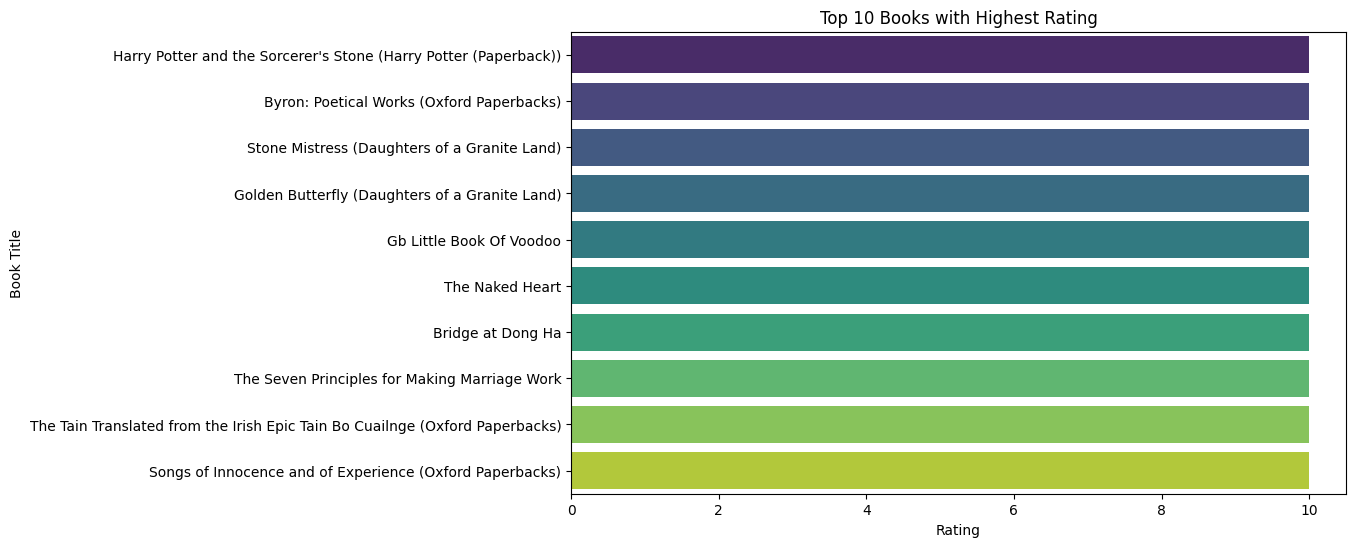

In [122]:
import seaborn as sns
top_books = fix_books.sort_values(by='bookRating', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='bookRating', y='title', data=top_books, palette='viridis')
plt.title('Top 10 Books with Highest Rating')
plt.xlabel('Rating')
plt.ylabel('Book Title')
plt.show()

10 Buku dengan Rating Terbanyak:
title
Wild Animus                                        2502
The Lovely Bones: A Novel                          1295
The Da Vinci Code                                   898
A Painted House                                     838
The Nanny Diaries: A Novel                          828
Bridget Jones's Diary                               815
The Secret Life of Bees                             774
Divine Secrets of the Ya-Ya Sisterhood: A Novel     740
The Red Tent (Bestselling Backlist)                 723
Angels &amp; Demons                                 670
Name: bookRating, dtype: int64


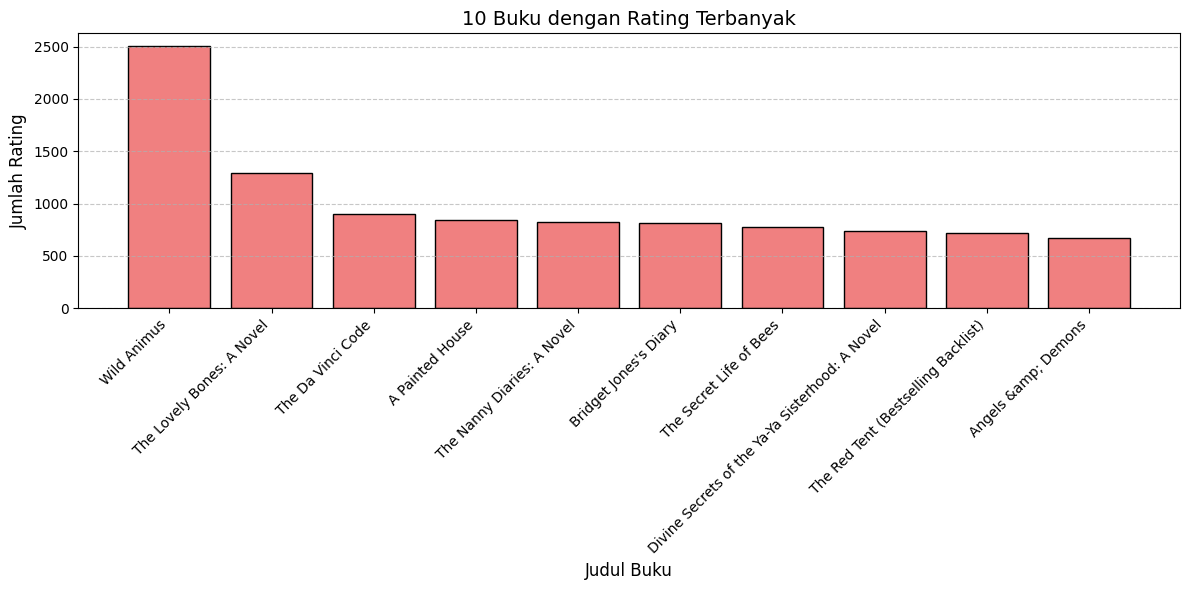

In [132]:

# Menghitung jumlah rating per buku
book_rating_counts = fix_books.groupby('title')['bookRating'].count()

# Menampilkan 10 buku dengan rating terbanyak
top_10_books_by_ratings = book_rating_counts.sort_values(ascending=False).head(10)

# Menampilkan informasi tentang 10 buku dengan rating terbanyak
print("10 Buku dengan Rating Terbanyak:")
print(top_10_books_by_ratings)

# Menyaring informasi dari 10 buku dengan rating terbanyak untuk visualisasi
top_10_books_info = fix_books[fix_books['title'].isin(top_10_books_by_ratings.index)].drop_duplicates(subset=['title'])

# Menambahkan kolom rating_count untuk visualisasi
top_10_books_info = top_10_books_info.set_index('title').loc[top_10_books_by_ratings.index]
top_10_books_info['rating_count'] = top_10_books_by_ratings.values

# Visualisasi 10 buku dengan rating terbanyak
plt.figure(figsize=(12, 6))

# Membuat bar plot dari 10 buku dengan rating terbanyak
plt.bar(top_10_books_info.index, top_10_books_info['rating_count'], color='lightcoral', edgecolor='black')

# Menambahkan judul dan label
plt.title('10 Buku dengan Rating Terbanyak', fontsize=14)
plt.xlabel('Judul Buku', fontsize=12)
plt.ylabel('Jumlah Rating', fontsize=12)

# Rotasi label judul buku agar lebih mudah dibaca
plt.xticks(rotation=45, ha='right')

# Menampilkan plot
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Agar tampilan lebih rapi
plt.show()

Diatas merupakan buku dengan jumlah rating terbanyak

Distribusi Tahun Penerbitan Buku:
year
0.0       4618
1376.0       1
1378.0       1
1806.0       1
1897.0       1
          ... 
2026.0       1
2030.0       7
2037.0       1
2038.0       1
2050.0       2
Name: count, Length: 116, dtype: int64


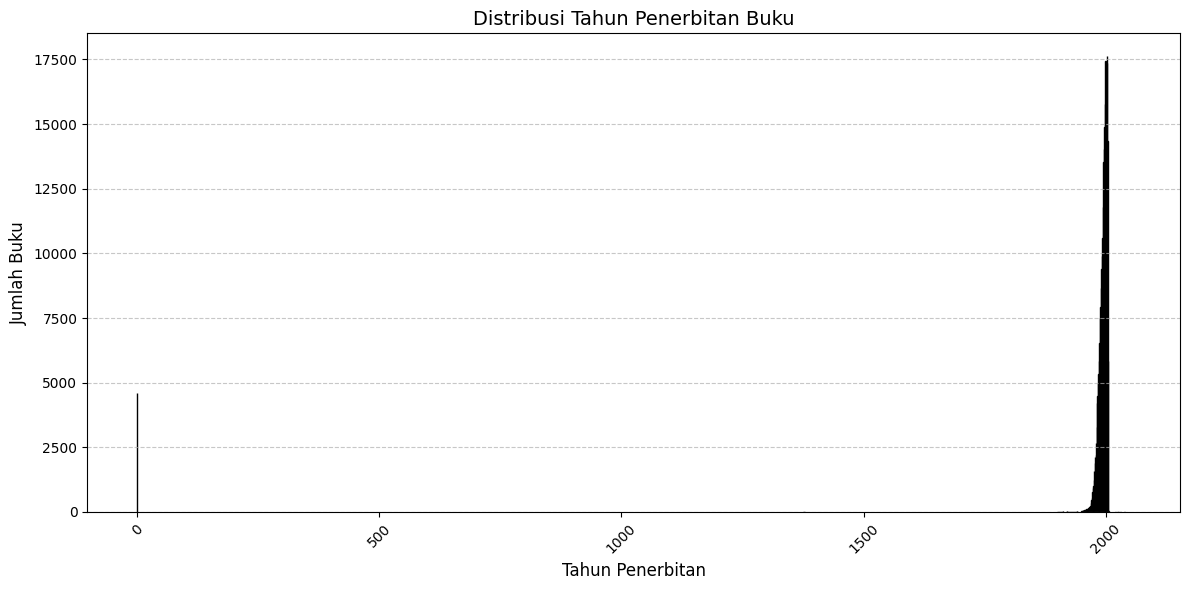

In [126]:
books['year'] = pd.to_numeric(books['year'], errors='coerce')
year_distribution = books['year'].value_counts().sort_index()

# Menampilkan distribusi tahun penerbitan
print("Distribusi Tahun Penerbitan Buku:")
print(year_distribution)

# Visualisasi distribusi tahun penerbitan buku
plt.figure(figsize=(12, 6))

# Membuat bar plot dari distribusi tahun penerbitan
plt.bar(year_distribution.index, year_distribution.values, color='skyblue', edgecolor='black')

# Menambahkan judul dan label
plt.title('Distribusi Tahun Penerbitan Buku', fontsize=14)
plt.xlabel('Tahun Penerbitan', fontsize=12)
plt.ylabel('Jumlah Buku', fontsize=12)

# Rotasi label tahun agar lebih mudah dibaca
plt.xticks(rotation=45)

# Menampilkan plot
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Agar tampilan lebih rapi
plt.show()

Dan diatas ini merupakan distribusi tahun penerbitan buku, bisa dilihat ada 4618 buku dengan nilai tahun penerbitan 0, buku tersebut akan dibersihkan.

In [25]:
zero_count = (fix_books['year'] == 0).sum()
zero_count

12744

In [26]:
fix_books = fix_books[fix_books['year'] != 0]
zero_count = (fix_books['year'] == 0).sum()
zero_count

0

**Penjelasan Mengapa Nilai 0 di Kolom `year` Harus Dibuang :**

* **Nilai 0 sebagai Null**: Dalam konteks data buku, nilai 0 pada kolom `year` mungkin berarti bahwa informasi tahun publikasi buku tidak tersedia atau tidak valid, yang menjadikannya setara dengan nilai kosong (null). Oleh karena itu, baris dengan nilai 0 di kolom `year` perlu dianggap sebagai data yang tidak lengkap atau tidak valid.

* **Menghapus Baris dengan Nilai 0**: Jika Anda menemukan nilai 0 pada kolom `year`, ini menandakan bahwa informasi tahun terbit buku tersebut hilang atau tidak tercatat dengan benar. Untuk memastikan analisis atau model rekomendasi berbasis data yang akurat dan konsisten, baris dengan nilai 0 di kolom `year` perlu dihapus.

In [27]:
zero_count = (fix_books['bookRating'] == 0).sum()
zero_count

639805

**Penjelasan Mengapa Nilai 0 di Kolom `bookRating` Tidak Dibuang :**

Nilai 0 pada kolom `bookRating` tidak perlu dibuang karena itu merupakan bentuk data yang sah yang mencerminkan tidak adanya rating eksplisit, dan bisa digunakan untuk membangun model rekomendasi yang lebih baik, baik dengan pendekatan rating eksplisit maupun implisit.

In [28]:
# Mengecek berapa jumlah fix_resto
len(fix_books.ISBN.unique())

266579

In [29]:
# Membuat variabel preparation yang berisi dataframe fix_resto kemudian mengurutkan berdasarkan placeID
preparation = fix_books
preparation.sort_values('ISBN')

,userID,ISBN,bookRating,title,author,year,publisher
703628,171118,0000913154,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster
357256,86123,0001010565,0,Mog's Christmas,Judith Kerr,1992,Collins
866078,209516,0001010565,0,Mog's Christmas,Judith Kerr,1992,Collins
807953,196149,0001046713,0,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers
103678,23902,000104687X,6,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993,HarperCollins Publishers
...,...,...,...,...,...,...,...
340229,81207,B0001PBXMS,0,"Love, etc.",Julian Barnes,2001,Knopf
1133070,271705,B0001PIOX4,0,Fahrenheit 451,Ray Bradbury,1993,Simon &amp; Schuster
423107,100906,B000234N3A,9,Fraud,David Rakoff,2001,Doubleday
1100731,264317,B000234N76,0,Falling Angels,Tracy Chevalier,2001,E P Dutton


**Penjelasan Kode :**

`preparation.drop_duplicates('ISBN')`: Fungsi `drop_duplicates()` digunakan untuk menghapus baris duplikat berdasarkan kolom tertentu, dalam hal ini berdasarkan kolom ISBN.

**Tujuan:**

**Menghapus Duplikat**: Kode ini digunakan untuk memastikan bahwa setiap buku hanya muncul satu kali dalam dataset berdasarkan nilai `ISBN`. Menghapus duplikat ini sangat penting untuk mencegah analisis atau model yang menganggap satu buku muncul lebih dari satu kali karena adanya entri yang duplikat.

In [30]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('ISBN')
preparation

,userID,ISBN,bookRating,title,author,year,publisher
703628,171118,0000913154,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster
357256,86123,0001010565,0,Mog's Christmas,Judith Kerr,1992,Collins
807953,196149,0001046713,0,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers
103678,23902,000104687X,6,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993,HarperCollins Publishers
853071,206300,0001046934,0,The Prime of Miss Jean Brodie,Muriel Spark,1999,Trafalgar Square Publishing
...,...,...,...,...,...,...,...
340229,81207,B0001PBXMS,0,"Love, etc.",Julian Barnes,2001,Knopf
1133070,271705,B0001PIOX4,0,Fahrenheit 451,Ray Bradbury,1993,Simon &amp; Schuster
423107,100906,B000234N3A,9,Fraud,David Rakoff,2001,Doubleday
1100731,264317,B000234N76,0,Falling Angels,Tracy Chevalier,2001,E P Dutton


**Penjelasan Kode :**

`tolist()`: Fungsi ini mengonversi data yang ada dalam kolom DataFrame menjadi bentuk list Python. Ini berguna jika Anda ingin menggunakan data tersebut dalam operasi atau model yang memerlukan format list.

In [31]:
# Mengonversi data series ‘placeID’ menjadi dalam bentuk list
book_id = preparation['ISBN'].tolist()

# Mengonversi data series ‘Name’ menjadi dalam bentuk list
title = preparation['title'].tolist()

# Mengonversi data series ‘Rcuisine’ menjadi dalam bentuk list
author = preparation['author'].tolist()

# Mengonversi data series ‘Rcuisine’ menjadi dalam bentuk list
year = preparation['year'].tolist()

# Mengonversi data series ‘Rcuisine’ menjadi dalam bentuk list
publisher = preparation['publisher'].tolist()

print(len(book_id))
print(len(title))
print(len(author))
print(len(year))
print(len(publisher))

266579
266579
266579
266579
266579


**Tujuan membuat df `books_new`:**

Kode ini membuat DataFrame baru yang mengorganisir data buku ke dalam kolom-kolom yang lebih mudah diakses dan dianalisis, seperti ISBN, judul, pengarang, tahun terbit, dan penerbit. Data ini dapat digunakan untuk analisis lebih lanjut atau sebagai bagian dari sistem rekomendasi buku.

In [32]:
# Membuat dataframe books_new
books_new = pd.DataFrame({
    'isbn': book_id,
    'book_title': title,
    'book_author': author,
    'year_of_publication': year,
    'publisher': publisher
})

books_new

,isbn,book_title,book_author,year_of_publication,publisher
0,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster
1,0001010565,Mog's Christmas,Judith Kerr,1992,Collins
2,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers
3,000104687X,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993,HarperCollins Publishers
4,0001046934,The Prime of Miss Jean Brodie,Muriel Spark,1999,Trafalgar Square Publishing
...,...,...,...,...,...
266574,B0001PBXMS,"Love, etc.",Julian Barnes,2001,Knopf
266575,B0001PIOX4,Fahrenheit 451,Ray Bradbury,1993,Simon &amp; Schuster
266576,B000234N3A,Fraud,David Rakoff,2001,Doubleday
266577,B000234N76,Falling Angels,Tracy Chevalier,2001,E P Dutton


In [33]:
books_new = books_new[:30000]
books_new
data = books_new

**Penjelasan Kode:**

`books_new[:30000]`: Kode ini digunakan untuk memotong DataFrame `books_new` sehingga hanya mengambil 30.000 baris pertama. Dalam hal ini, **slicing** digunakan untuk memilih subset data dari baris pertama hingga baris ke-30.000.

**Tujuan :**

Kode ini digunakan untuk membatasi jumlah data dalam DataFrame `books_new` menjadi 30.000 baris pertama, yang bisa berguna untuk mengurangi ukuran dataset ketika mengerjakan proses analisis atau pemodelan yang memerlukan waktu komputasi lebih cepat atau memori yang lebih rendah.

# **3.** **Modelling**

## **3.1** **Content Based Filtering menggunakan TF-IDF**

### **Data Preparation**

## **TF-IDF (Term Frequency-Inverse Document Frequency)**

TF-IDF adalah teknik yang digunakan untuk mengukur seberapa penting suatu kata dalam sebuah dokumen dibandingkan dengan kumpulan dokumen lain. TF-IDF terdiri dari dua komponen utama: **Term Frequency (TF)** dan **Inverse Document Frequency (IDF)**.

### 1. Term Frequency (TF)

TF mengukur seberapa sering suatu kata muncul dalam dokumen tertentu.

Rumus untuk TF adalah:

$$
TF(t, d) = \frac{\text{Jumlah kemunculan kata } t \text{ di dokumen } d}{\text{Total kata dalam dokumen } d}
$$

**Contoh**: Jika kata “buku” muncul 5 kali dalam dokumen yang berisi 100 kata, maka TF untuk kata "buku" adalah 5/100 = 0,05.

### 2. Inverse Document Frequency (IDF)

IDF mengukur seberapa umum atau jarang suatu kata dalam keseluruhan kumpulan dokumen. Kata yang sering muncul di banyak dokumen (misalnya "dan", "atau") akan memiliki nilai IDF rendah, sedangkan kata yang jarang muncul di banyak dokumen akan memiliki nilai IDF tinggi.

Rumus untuk IDF adalah:

$$
IDF(t) = \log\left(\frac{\text{Total jumlah dokumen}}{\text{Jumlah dokumen yang mengandung kata } t}\right)
$$

**Contoh**: Jika terdapat 10.000 dokumen dan kata "rekomendasi" hanya muncul di 100 dokumen, maka IDF-nya adalah \( \log(10000 / 100) = 2 \).

### 3. Menghitung Nilai TF-IDF

TF-IDF dari suatu kata dihitung dengan mengalikan TF dan IDF dari kata tersebut:

$$
\text{TF-IDF}(t, d) = TF(t, d) \times IDF(t)
$$

Semakin tinggi nilai TF-IDF, semakin penting kata tersebut dalam dokumen tertentu dan semakin jarang muncul di dokumen lain.

### Cara Kerja TF-IDF Secara Keseluruhan

1. **Langkah 1**: Hitung nilai TF untuk setiap kata dalam dokumen.
2. **Langkah 2**: Hitung nilai IDF untuk setiap kata berdasarkan keseluruhan kumpulan dokumen.
3. **Langkah 3**: Kalikan TF dan IDF untuk mendapatkan nilai TF-IDF, yang menunjukkan kepentingan kata dalam dokumen relatif terhadap kumpulan dokumen lainnya.

### Tujuan TF-IDF dalam Analisis Teks

TF-IDF membantu dalam menyoroti kata-kata yang memiliki makna penting dan membedakan dokumen, sehingga sangat bermanfaat dalam analisis teks, pemrosesan bahasa alami (NLP), dan berbagai aplikasi seperti pencarian informasi, sistem rekomendasi, serta klasifikasi teks.


In [34]:
# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

### **Penjelasan:**

* `TfidfVectorizer()`: `TfidfVectorizer` adalah fungsi dari pustaka `scikit-learn` yang digunakan untuk mengonversi teks menjadi representasi numerik berbasis TF-IDF (Term Frequency-Inverse Document Frequency). TF-IDF adalah metode untuk mengukur seberapa penting suatu kata dalam dokumen tertentu relatif terhadap seluruh kumpulan dokumen.

* Inisialisasi: Dengan inisialisasi `TfidfVectorizer()` tanpa parameter tambahan, objek `tfidf` siap digunakan untuk menerapkan TF-IDF pada data teks. Anda dapat menggunakan metode `fit_transform` dari `tfidf` ini untuk langsung mengonversi teks menjadi vektor TF-IDF.

In [35]:
# Menggabungkan Book-Title dan Book-Author
combined = data['book_title'] + ' ' + data['book_author']

# Menggunakan TF-IDF pada combined features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(combined)

# Membuat DataFrame untuk melihat TF-IDF matrix
tfidf_df = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=data.book_title  # Atau index lainnya yang relevan
).sample(15, axis=1).sample(10, axis=0)


**Kode di atas melakukan proses berikut:**

1. **Menggabungkan Kolom `book_title` dan `book_author`**: Menggabungkan judul buku dan nama penulis menjadi satu string untuk menciptakan fitur teks baru yang lebih kaya, disimpan dalam variabel `combined`.

2. **Mengaplikasikan TF-IDF**: Menggunakan `TfidfVectorizer` untuk menghitung bobot TF-IDF dari kata-kata dalam fitur gabungan (`combined`). `stop_words='english'` mengabaikan kata-kata umum (seperti “the” dan “and”) yang tidak memiliki arti spesifik.

3. **Membuat DataFrame TF-IDF**: DataFrame `tfidf_df` dibentuk dari hasil TF-IDF, di mana kolomnya adalah fitur kata-kata yang dipilih secara acak dari vektor TF-IDF. Baris indeks menggunakan `book_title` sebagai referensi tiap buku.

Sampling digunakan untuk menampilkan subset 10 buku dan 15 fitur, mempermudah visualisasi dalam analisis awal.


In [36]:
tfidf_df

,gale,thicker,dimity,padraic,sone,activation,juster,decorative,boehmer,axtell,institution,fitness,rendering,rhinoceros,godden
book_title,,,,,,,,,,,,,,,
Free Again (Phantom Stallion #5),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Fragrance of Basil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Three Astronauts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Journey Through Wales and the Description of Wales (Penguin Classics),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Voyage of the Dawn Treader,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Soldier Boy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I Stay Near You: 1 Story in 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
An Echo in My Blood: The Search for My Family's Hidden Past,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Seven-Day Magic (Odyssey Classic),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Cosine Similarity**

**Cosine Similarity** adalah ukuran untuk menghitung seberapa mirip dua vektor dalam ruang n-dimensi. Dalam konteks ini, vektor adalah representasi numerik dari buku yang diperoleh menggunakan TF-IDF. Cosine similarity mengukur sudut antara dua vektor; semakin kecil sudutnya, semakin mirip vektor tersebut.

1. **Vektor TF-IDF**: Setiap buku diwakili sebagai vektor berdasarkan frekuensi kata yang ada di dalamnya. Semakin sering sebuah kata muncul dalam buku, semakin tinggi nilai TF-IDF-nya, yang menunjukkan pentingnya kata tersebut untuk buku tersebut.

2. **Penghitungan Cosine Similarity**:
   - **Cosine similarity** dihitung dengan rumus berikut:
   
   $$ \text{cosine_similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|} $$

   Di mana:
   - \( A \cdot B \) adalah hasil perkalian titik (dot product) antara dua vektor A dan B.
   - \( \|A\| \) dan \( \|B\| \) adalah panjang (magnitude) dari masing-masing vektor.

   Semakin tinggi nilai cosine similarity, semakin mirip kedua vektor tersebut. Nilai cosine similarity berkisar antara 0 (tidak mirip sama sekali) hingga 1 (sangat mirip).

3. **Penerapan pada TF-IDF Matrix**:
   - Ketika kita menerapkan cosine similarity pada matrix TF-IDF, kita menghitung kemiripan antara semua pasangan buku di dalam dataset. Matriks hasil cosine similarity akan menunjukkan skor kemiripan antara setiap buku dengan buku lainnya.


In [37]:
# Calculating cosine similarity on the tf-idf matrix
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.6214954,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.6214954, 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.       ]])

Kode ini menghitung **cosine similarity** antar buku berdasarkan vektor TF-IDF yang telah dihitung sebelumnya:

1. **Cosine Similarity**: Fungsi `cosine_similarity` digunakan untuk mengukur seberapa mirip dua vektor dalam ruang fitur. Dalam konteks ini, vektor yang dimaksud adalah representasi TF-IDF dari judul dan penulis buku. Nilai cosine similarity berkisar antara 0 (tidak mirip) hingga 1 (sangat mirip).

2. **Penerapan pada TF-IDF Matrix**: Fungsi `cosine_similarity(tfidf_matrix)` diterapkan pada matrix TF-IDF yang telah dihitung sebelumnya. Hasilnya adalah sebuah matriks yang menunjukkan tingkat kemiripan antara setiap pasangan buku.


In [38]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama buku
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['book_title'], columns=data['book_title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap buku
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (30000, 30000)


book_title,The Duke's Children (Penguin Classics),Edna St. Vincent Millay: Selected Poems : The Centenary Edition,How Paul Robeson Saved My Life and Other Mostly Happy Stories,African Myths and Legends (Oxford Myths and Legends),The Practical Writer: From Inspiration to Publication
book_title,,,,,
Healing With Love: A Physician's Breakthrough Mind/Body Medical Guide for Healing Yourself and Others : The Art of Holoenergetic Healing,0.0,0.0,0.000000,0.000000,0.0
Build Your Own Pentium III PC,0.0,0.0,0.000000,0.000000,0.0
Shrek Gag Book,0.0,0.0,0.000000,0.000000,0.0
The New Oxford Book of Canadian Short Stories in English,0.0,0.0,0.059962,0.048336,0.0
Rise to Globalism: American Foreign Policy Since 1938,0.0,0.0,0.000000,0.000000,0.0
"Sailing to Cythera: And Other Anatole Stories (Anatole Trilogy, Book 1)",0.0,0.0,0.038302,0.000000,0.0
Autonomy of Religious Belief,0.0,0.0,0.000000,0.000000,0.0
A Year Down Yonder,0.0,0.0,0.000000,0.000000,0.0
Impostors,0.0,0.0,0.000000,0.000000,0.0


In [39]:
def book_recommendations(nama_buku, similarity_data=cosine_sim_df, items=data[['book_title', 'book_author']], k=10):
    """
    Rekomendasi Resto berdasarkan kemiripan dataframe

    Parameter:
    ---
    nama_buku : tipe data string (str)
                Nama Restoran (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan resto sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_buku].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_buku agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_buku, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [40]:

book_title_test = "Little Wolf's Book of Badness" # book title example

data[data.book_title.eq(book_title_test)]

,isbn,book_title,book_author,year_of_publication,publisher
50,0001857258,Little Wolf's Book of Badness,Ian Whybrow,1999,Collins


In [41]:
# Get recommendations for similar book titles
book_recommendations(book_title_test)

,book_title,book_author
0,Little Wolf's Big Book of Badness and Daring D...,Ian Whybrow
1,Little Wolf's Postbag,Ian Whybrow
2,Little Wolf's Handy Book of Peoms,Ian Whybrow
3,"Little Wolf, Pack Leader",Ian Whybrow
4,Wolf &amp; the Seven Kids (A first little gold...,Golden Books
5,Wolf Children,Charles MacLean
6,Small Wolf (I Can Read Book 3),Nathaniel Benchley
7,The WOLF,Margaret Barbalet
8,Best Little Word Book Ever! (Little Golden Book),RICHARD SCARRY
9,Children of the Wolf,Jane Yolen


### **Menghitung Precision untuk Sistem Rekomendasi**

**Precision** mengukur seberapa banyak dari rekomendasi yang diberikan relevan dengan apa yang dicari oleh pengguna. Precision dapat dihitung dengan rumus berikut:

$$
\text{Precision} = \frac{\text{Jumlah rekomendasi yang relevan}}{\text{Jumlah item yang direkomendasikan}}
$$

**Contoh Kasus:**

1. **Input**: Judul buku yang dicari adalah "*Little Wolf's Book of Badness*".
2. **Output**: Sistem memberikan daftar buku yang direkomendasikan yang terkait dengan judul tersebut.

#### Langkah-langkah Menghitung Precision:
- **Buku yang relevan**: Buku yang memiliki kaitan erat dengan judul buku yang diberikan. Dalam hal ini, buku yang relevan adalah yang memiliki "Little Wolf" dalam judulnya.
- **Jumlah rekomendasi yang relevan**: Buku yang relevan dengan input, yaitu buku yang judulnya mengandung "Little Wolf".
- **Jumlah item yang direkomendasikan**: Jumlah total buku yang direkomendasikan oleh sistem, dalam hal ini adalah 10.

#### Output dari rekomendasi:
Dari output yang diberikan, kita melihat ada **9 buku** yang relevan berdasarkan judulnya (semuanya mengandung "Little Wolf").

#### Menghitung Precision:
$$
\text{Precision} = \frac{9}{10} = 0.9
$$

**Kesimpulan :**

Jadi, **precision** untuk rekomendasi ini adalah **0.9** atau 90%.


## **3.2** **Collaborative Filtering**

Mengambil 30000 data dari data `ratings`

### **Data Preparation**

In [42]:
df = ratings[:30000]
df.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


**Proses Encoding userID**

* Mengambil nilai unik dari `userID` dalam DataFrame dan mengubahnya menjadi list.
* Melakukan encoding pada `userID` dengan memberikan angka unik untuk setiap `userID` yang ada.
* Membalikkan encoding untuk mengonversi angka kembali ke `userID` asli.

Ini berguna untuk mempersiapkan data `userID` agar bisa digunakan dalam model machine learning yang memerlukan data numerik.

In [43]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['userID'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [276725, 276726, 276727, 276729, 276733, 276736, 276737, 276744, 276745, 276746, 276747, 276748, 276751, 276754, 276755, 276760, 276762, 276765, 276768, 276772, 276774, 276780, 276786, 276788, 276796, 276798, 276800, 276803, 276804, 276806, 276808, 276811, 276812, 276813, 276814, 276817, 276820, 276822, 276827, 276828, 276830, 276832, 276833, 276835, 276837, 276838, 276840, 276842, 276847, 276848, 276850, 276852, 276853, 276854, 276856, 276857, 276859, 276861, 276862, 276863, 276866, 276869, 276870, 276872, 276873, 276875, 276878, 276879, 276884, 276887, 276888, 276889, 276890, 276896, 276904, 276905, 276911, 276912, 276915, 276916, 276925, 276927, 276928, 276929, 276934, 276936, 276939, 276943, 276946, 276949, 276950, 276953, 276954, 276957, 276959, 276963, 276964, 276965, 276975, 276981, 276984, 276986, 276988, 276989, 276990, 276992, 276994, 276997, 276998, 277002, 277007, 277009, 277010, 277012, 277018, 277019, 277022, 277023, 277028, 277031, 277032, 277035, 277036, 2

**Proses Encoding ISBN**

1. **Mengambil nilai unik dari `ISBN`** dan mengubahnya menjadi list tanpa duplikat.
2. **Melakukan encoding** pada `ISBN` dengan memberikan angka unik untuk setiap ISBN.
3. **Membalikkan encoding** untuk mengonversi angka kembali ke ISBN asli.

Tujuan dari proses ini adalah untuk mengubah data `ISBN` yang berbentuk teks menjadi format numerik agar dapat digunakan dalam model machine learning.


In [44]:
# Mengubah ISBN menjadi list tanpa nilai yang sama
book_ids = df['ISBN'].unique().tolist()

# Melakukan proses encoding ISBN
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}

# Melakukan proses encoding angka ke ISBN
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

In [45]:
# Mapping userID ke dataframe user
df['user'] = df['userID'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
df['book'] = df['ISBN'].map(book_to_book_encoded)

<ipython-input-45-a6fafe9fdb3f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user'] = df['userID'].map(user_to_user_encoded)
<ipython-input-45-a6fafe9fdb3f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['book'] = df['ISBN'].map(book_to_book_encoded)


In [46]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah resto
num_book = len(book_encoded_to_book)
print(num_book)

# Mengubah rating menjadi nilai float
df['bookRating'] = df['bookRating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['bookRating'])

# Nilai maksimal rating
max_rating = max(df['bookRating'])

print('Number of User: {}, Number of Book: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_book, min_rating, max_rating
))

3445
24009
Number of User: 3445, Number of Resto: 24009, Min Rating: 0.0, Max Rating: 10.0


<ipython-input-46-e76ed63d37c2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bookRating'] = df['bookRating'].values.astype(np.float32)


### Melakukan pengacakan dataset

In [47]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userID,ISBN,bookRating,user,book
2308,277554,0449907481,0.0,302,2046
22404,4667,0553574132,0.0,2516,19022
23397,5350,3492045170,0.0,2748,752
25058,6007,0671004107,0.0,3010,14572
2664,277639,0679445099,0.0,335,2561
...,...,...,...,...,...
29802,6968,0345291409,0.0,3400,23885
5390,278418,0373121962,0.0,678,5066
860,277087,8472230082,5.0,139,850
15795,2442,8804320095,0.0,1706,13939


### **Data Splitting**

`train_indices = int(0.8 * df.shape[0])`

Membagi data menjadi 80:20

In [48]:
# Membuat variabel x untuk mencocokkan data user dan book menjadi satu value
x = df[['user', 'book']].values

# Membuat variabel y untuk membuat bookRating dari hasil
y = df['bookRating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[  302  2046]
 [ 2516 19022]
 [ 2748   752]
 ...
 [  139   850]
 [ 1706 13939]
 [ 2804 19921]] [0.  0.  0.  ... 0.5 0.  0.7]


Inisiasi fungsi model rekomendasi buku

In [112]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf

class OptimizedRecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_book, embedding_size, **kwargs):
        super(OptimizedRecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_book = num_book
        self.embedding_size = embedding_size

        # Embedding Layers
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding(
            num_book,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.book_bias = layers.Embedding(num_book, 1)

        # Hidden layers with Batch Normalization
        self.dense1 = layers.Dense(256, activation=None, kernel_regularizer=regularizers.l2(1e-6))
        self.bn1 = layers.BatchNormalization()
        self.dense2 = layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(1e-6))
        self.bn2 = layers.BatchNormalization()
        self.dense3 = layers.Dense(64, activation=None, kernel_regularizer=regularizers.l2(1e-6))
        self.bn3 = layers.BatchNormalization()

        # Dropout untuk mencegah overfitting
        self.dropout = layers.Dropout(0.6)

        # Output layer untuk menghasilkan satu nilai prediksi (misal rating)
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])  # User embedding
        user_bias = self.user_bias(inputs[:, 0])  # User bias
        book_vector = self.book_embedding(inputs[:, 1])  # Book embedding
        book_bias = self.book_bias(inputs[:, 1])  # Book bias

        # Dot product untuk interaksi antara user dan book
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)

        # Tambahkan bias
        x = dot_user_book + user_bias + book_bias

        # Hidden layers dengan Batch Normalization
        x = self.dense1(x)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.dense2(x)
        x = self.bn2(x)
        x = self.dense3(x)
        x = self.bn3(x)
        x = tf.nn.relu(x)

        # Dropout setelah hidden layers
        x = self.dropout(x)

        # Output layer dengan activation sigmoid
        return self.output_layer(x)

### Penjelasan Kode:

1. **Inisialisasi Model:**
   - `model = OptimizedRecommenderNet(num_users, num_book, 50)`:
     - Membuat objek model `OptimizedRecommenderNet` dengan jumlah pengguna (`num_users`), jumlah buku (`num_book`), dan ukuran embedding (`embedding_size = 50`).

2. **Learning Rate Scheduler:**
   - `lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 0.9**epoch, verbose=1)`:
     - Mengatur penjadwalan learning rate menggunakan callback `LearningRateScheduler`.
     - Pada setiap epoch, learning rate akan dikurangi sebesar 10% (`0.9**epoch`) dari learning rate awal (`1e-4`).
     - `verbose=1` menampilkan informasi perubahan learning rate setiap kali epoch dimulai.

3. **Model Compile:**
   - `model.compile(...)`:
     - Menyusun model dengan optimizer Adam menggunakan learning rate awal `1e-4`.
     - Loss function yang digunakan adalah `BinaryCrossentropy`, yang cocok untuk masalah klasifikasi biner (misalnya: rating positif atau negatif).
     - Metrik yang digunakan adalah `RootMeanSquaredError` untuk mengukur akurasi prediksi model berdasarkan kesalahan kuadrat akar.


In [113]:
from tensorflow import keras
model = OptimizedRecommenderNet(num_users, num_book, 50)  # Inisialisasi model

# Model Compile dengan Learning Rate Scheduling dan Early Stopping
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 0.9**epoch, verbose=1)

# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

### Penjelasan Kode:

1. **Training Model (`fit`)**:
   - `history = model.fit(...)`:
     - Melatih model menggunakan data pelatihan (`x_train`, `y_train`) dengan parameter berikut:

2. **Input Data**:
   - `x = x_train`: Data fitur untuk pelatihan.
   - `y = y_train`: Target output atau label untuk data pelatihan.
   - `validation_data = (x_val, y_val)`: Data validasi yang digunakan untuk mengevaluasi performa model selama pelatihan.

3. **Parameter Pelatihan**:
   - `batch_size = 32`: Menentukan jumlah sampel dalam satu batch untuk setiap iterasi pelatihan.
   - `epochs = 8`: Model akan dilatih selama 8 epoch (satu iterasi penuh melalui seluruh dataset pelatihan).

4. **Callbacks**:
   - `callbacks=[lr_scheduler]`: Menggunakan callback untuk penjadwalan learning rate selama pelatihan, yang sudah dijelaskan sebelumnya dengan penurunan learning rate setiap epoch (`lr_scheduler`).

In [114]:
# Fit model dengan callbacks untuk early stopping dan learning rate scheduling
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 8,
    validation_data = (x_val, y_val),
    callbacks=[lr_scheduler]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/8
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.6298 - root_mean_squared_error: 0.3983 - val_loss: 0.5657 - val_root_mean_squared_error: 0.3670 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9e-05.
Epoch 2/8
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.5521 - root_mean_squared_error: 0.3604 - val_loss: 0.5510 - val_root_mean_squared_error: 0.3596 - learning_rate: 9.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 8.1e-05.
Epoch 3/8
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.5278 - root_mean_squared_error: 0.3488 - val_loss: 0.5455 - val_root_mean_squared_error: 0.3562 - learning_rate: 8.1000e-05

Epoch 4: LearningRateScheduler setting learning rate to 7.290000000000001e-05.
Epoch 4/8
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.5143 - root_mean_squared_error: 0.3402 - val_loss: 0.5437 - val_root_mean_squared_error: 0.3545 - lea

Mengambil sample `userID`

In [118]:
book_df = books_new

# take a sample of users
user_id = df['userID'].sample(1).iloc[0]
book_readed_by_user = df[df['userID'] == user_id]

# create variable book_not_readed
book_not_readed = book_df[~book_df['isbn'].isin(book_readed_by_user['ISBN'].values)]['isbn']
book_not_readed = list(
    set(book_not_readed)
    .intersection(set(book_to_book_encoded.keys()))
)

book_not_readed = [[book_to_book_encoded.get(x)] for x in book_not_readed]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_readed), book_not_readed)
)

Melakukan rekomendasi terhadap `userID` yang telah diambil

In [119]:
ratings_model = model.predict(user_book_array).flatten()

top_ratings_indices = ratings_model.argsort()[-10:][::-1]

recommended_book_ids = [
    book_encoded_to_book.get(book_not_readed[x][0]) for x in top_ratings_indices
]

top_book_user = (
    book_readed_by_user.sort_values(
        by='bookRating',
        ascending=False
    )
    .head(10)['ISBN'].values
)

book_df_rows = book_df[book_df['isbn'].isin(top_book_user)]

# Displays book recommendations in DataFrame form
book_df_rows_data = []
for row in book_df_rows.itertuples():
    book_df_rows_data.append([row.book_title, row.book_author])

recommended_book = book_df[book_df['isbn'].isin(recommended_book_ids)]

recommended_book_data = []
for row in recommended_book.itertuples():
    recommended_book_data.append([row.book_title, row.book_author])

# Create a DataFrame for output
output_columns = ['Book Title', 'Book Author']
df_book_readed_by_user = pd.DataFrame(book_df_rows_data, columns=output_columns)
df_recommended_books = pd.DataFrame(recommended_book_data, columns=output_columns)

# Displays recommendation results in DataFrame form
print("Showing recommendation for users: {}".format(user_id))
print("===" * 9)
print("Book with high ratings from user")
print("----" * 8)
print(df_book_readed_by_user)
print("----" * 8)
print("Top 10 books recommendation")
print("----" * 8)
df_recommended_books

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Showing recommendation for users: 2103
Book with high ratings from user
--------------------------------
                                          Book Title    Book Author
0  Home Tree Home: Principles of Treehouse Constr...   Peter Nelson
1  Sherlock Holmes and the Rune Stone Mystery (Sh...  Larry Millett
2               The Disappearance of Sherlock Holmes  Larry Millett
--------------------------------
Top 10 books recommendation
--------------------------------


,Book Title,Book Author
0,Anam Cara : A Book of Celtic Wisdom,John O'Donohue
1,Judge Judy Sheindlin's Win or Lose by How You ...,Judge Judy Sheindlin
2,Ella Enchanted (rack),Gail Carson Levine
3,Two Old Women,Velma Wallis
4,Suddenly,Barbara Delinsky
5,Prey: A Novel,Michael Crichton
6,The Second Rumpole Omnibus (Crime Monthly),John Mortimer
7,The Wonderful Story of Henry Sugar and Six More,Roald Dahl
8,Eden Close,Anita Shreve
9,Including Students with Special Needs: A Pract...,Marilyn Penovich Friend


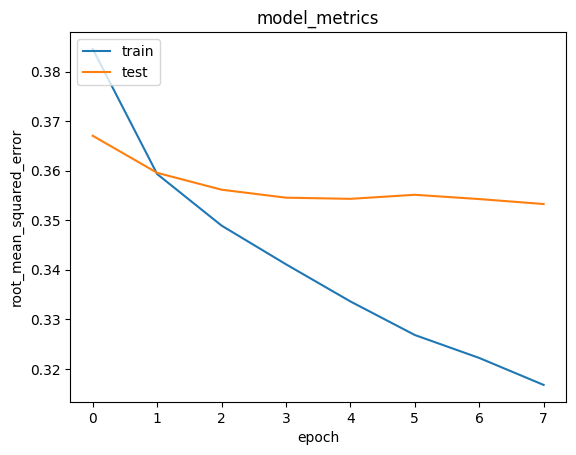

In [115]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **Hasil Model:**

- **Loss**: 0.4754
  - Loss menunjukkan nilai kerugian model selama pelatihan. Nilai loss yang lebih rendah menunjukkan bahwa model semakin baik dalam memprediksi target.

- **Root Mean Squared Error (RMSE)**: 0.3143
  - RMSE adalah metrik yang mengukur seberapa jauh prediksi model dari nilai sebenarnya. Nilai RMSE yang lebih rendah menunjukkan performa model yang lebih baik.

- **Validation Loss**: 0.5412
  - Validasi loss mengukur seberapa baik model pada data validasi. Model mengalami peningkatan pada validasi loss, yang menunjukkan bahwa model mungkin mulai overfit atau masih dapat diperbaiki.

- **Validation RMSE**: 0.3533
  - Validasi RMSE menunjukkan kesalahan rata-rata model pada data validasi. Meskipun lebih tinggi dari RMSE pelatihan, ini memberi gambaran seberapa baik model dapat diterapkan pada data baru.

### **Kesimpulan:**
Model menunjukkan performa yang baik pada data pelatihan, dengan nilai RMSE yang relatif rendah. Namun, ada sedikit peningkatan pada validasi loss dan validasi RMSE, yang bisa mengindikasikan bahwa model mulai mengalami overfitting atau masih membutuhkan peningkatan lebih lanjut. Penyesuaian lebih lanjut seperti penggunaan regularisasi atau lebih banyak epoch bisa membantu mengurangi gap antara pelatihan dan validasi performance.
